### PyTorch AlexNet Exercises

Welcome to the PyTorch AlexNet exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.






In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
from torchinfo import summary
import matplotlib.pyplot as plt

from AlexNet import BasicAlexNet

basicAlexnet = BasicAlexNet(num_classes=200)
print(summary(basicAlexnet, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
BasicAlexNet                             [1, 200]                  --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

I will use optuna for hyperparameter tuning of a basic AlexNet architecture.

The code goal is to combine several learning outcomes:
1. This code will take a search space dict as a parameter and perform a grid search
2. The model will always save the trials
3. A plot of accuracy and loss on both training and validation is done by the end of each trial

In [4]:
# Hyperparameters
learning_rates = [0.1, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
#momentums = [0.9, 0.95] Dropped because its takes too long to train
weight_decays = [1e-4, 5e-4]
num_epochs = 20


def objective(trial):
    basicAlexnet = BasicAlexNet(num_classes=3)
    
    lr = trial.suggest_categorical('lr', learning_rates)
    batch_size = trial.suggest_categorical('batch_size', batch_sizes)
    #momentum = trial.suggest_categorical('momentum', momentums)
    weight_decay = trial.suggest_categorical('weight_decay', weight_decays)


    # Define transforms for the input data
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to match AlexNet input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the Tiny ImageNet dataset
    # Note: You'll need to download the dataset and set the correct path.
    train_dataset = datasets.ImageFolder('C:\\Users\\a_h9\\Desktop\\Lab1\\dataset\\tiny-imagenet-200\\val3', transform=transform)
    val_dataset = datasets.ImageFolder('C:\\Users\\a_h9\\Desktop\\Lab1\\dataset\\tiny-imagenet-200\\train3', transform=transform)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(basicAlexnet.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Train the network
    for epoch in range(num_epochs):
        # Training loop
        basicAlexnet.train()
        train_loss = 0
        correct = 0
        total = 0
        
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = basicAlexnet(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)
        
        
        # Validation loop
        basicAlexnet.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = basicAlexnet(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100. * correct / total)
    
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')
    
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    torch.save(basicAlexnet.state_dict(), f'/saved_trials/model_trial_{trial.number}.pth')

    return val_losses[-1]

[I 2024-04-12 13:20:00,029] A new study created in memory with name: alexnet_tiny_imagenet


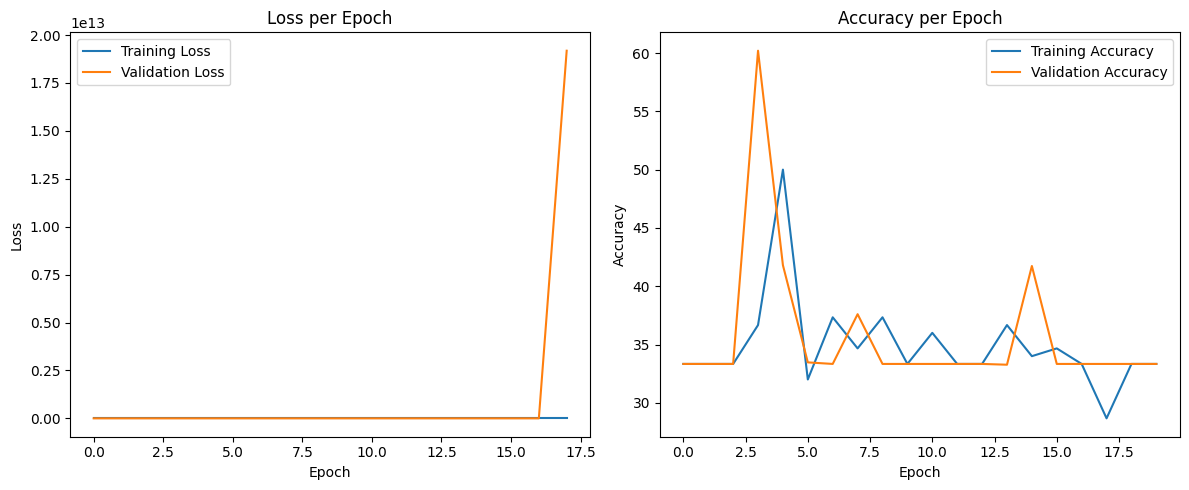

[W 2024-04-12 13:29:22,069] Trial 0 failed with parameters: {'lr': 0.1, 'batch_size': 64, 'momentum': 0.95, 'weight_decay': 0.0005} because of the following error: The value nan is not acceptable.
[W 2024-04-12 13:29:22,080] Trial 0 failed with value nan.


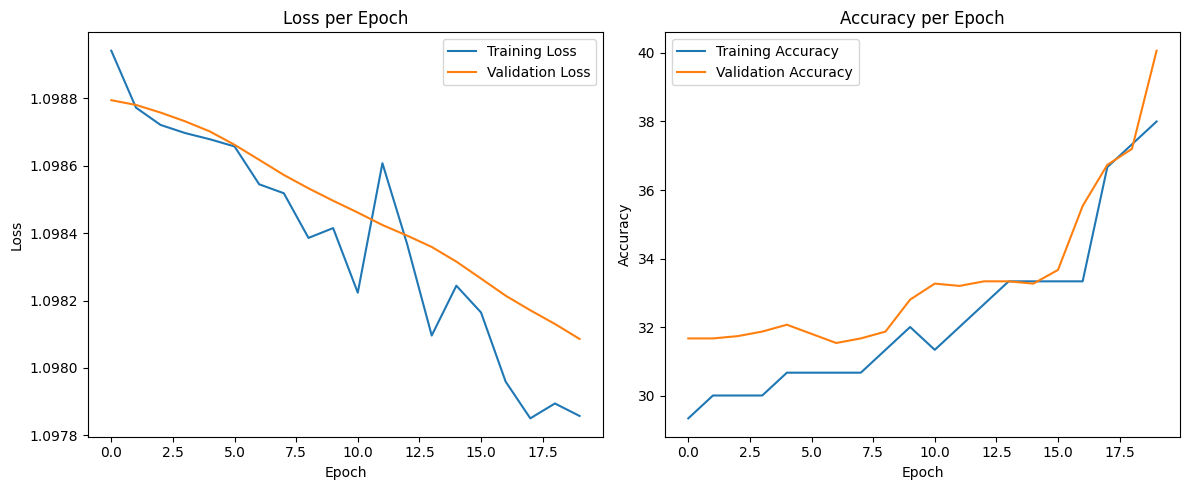

[I 2024-04-12 13:38:50,901] Trial 1 finished with value: 1.0980860739946365 and parameters: {'lr': 0.001, 'batch_size': 64, 'momentum': 0.9, 'weight_decay': 0.0001}. Best is trial 1 with value: 1.0980860739946365.
[W 2024-04-12 13:41:46,668] Trial 2 failed with parameters: {'lr': 0.0001, 'batch_size': 32, 'momentum': 0.9, 'weight_decay': 0.0005} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\a_h9\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\a_h9\AppData\Local\Temp\ipykernel_14436\1033545436.py", line 74, in objective
    outputs = basicAlexnet(inputs)
              ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\a_h9\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^

KeyboardInterrupt: 

In [5]:
import optuna

search_space = {
    'lr': learning_rates,
    'batch_size': batch_sizes,
    #'momentum': momentums,
    'weight_decay': weight_decays
}

sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='alexnet_tiny_imagenet')
study.optimize(objective, n_trials=None) 


# Print the best parameters
print('Best trial:')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')